In [1]:
# 必要なパッケージを呼び出す
using LinearAlgebra
using NLsolve
using Statistics
using Plots
using Interpolations
using DelimitedFiles
using Printf

In [2]:
# MATLABではグローバル変数を使って関数への変数受け渡しを行う

# ギリシャ文字の使用は不可とする
struct Model{TI<:Integer, TF<:AbstractFloat}

    # カリブレーション
    beta::TF           # 割引因子
    gamma::TF          # 相対的危険回避度(異時点間の代替の弾力性の逆数)
    alpha::TF          # 資本分配率
    delta::TF          # 固定資本減耗(delta=1.0のときは解析解が存在)  

    #定常状態の値
    ykss::TF
    kss::TF
    yss::TF
    css::TF 

    #グリッドに関するパラメータ
    kmax::TF           # 資本グリッドの最大値
    kmin::TF           # 資本グリッドの最小値
    nk::TI             # グリッドの数
    kgrid::Array{TF,1} # 資本グリッド

    #時間反復法に関するパラメータ
    maxiter::TI        # 繰り返し計算の最大値
    tol::TF            # 許容誤差

end

In [3]:
function mu_CRRA(cons,gamma)
    """
    --------------------------
    === CRRA型限界効用関数 ===
    --------------------------
    <inputs>
    ・cons: 消費量
    ・gamma: 相対的リスク回避度(異時点間の代替弾力性の逆数)
    <output>
    ・consとgamma の下での限界効用水準
    """

    mu = cons^(-gamma)

    return mu
    
end

mu_CRRA (generic function with 1 method)

In [4]:
function Euler_Eq(m,x,capital,cfcn)
    """
    -----------------------------------------------
    === オイラー方程式に代入した際の残差を返す関数 ===
    -----------------------------------------------
    <input>
    ・m: パラメータ等を含む構造体
    ・x: 今期の消費量(nlsolveの利用上ベクトル表記する)
    ・capital: 今期の資本保有量
    ・cfcn: 消費関数
    <output>
    ・res: オイラー方程式に代入した際の残差
    """

    cons = x[1]
    wealth = capital^m.alpha + (1-m.delta)*capital;
    kprime = wealth - cons;
    
    # トリック: k'は正の値しか取らない
    kprime = max(m.kgrid[1],kprime);

    # 次期の政策関数を線形補間
    c_interp = LinearInterpolation(m.kgrid,cfcn);
    cnext = c_interp(kprime);

    # オイラー方程式の残差を求める(u'(c)をmu_CRRA関数を用いて計算している)
    res = mu_CRRA(cons,m.gamma) - m.beta*mu_CRRA(cnext,m.gamma)*(m.alpha*kprime^(m.alpha-1) + (1 - m.delta));

    return res
end

Euler_Eq (generic function with 1 method)

In [5]:
# メインファイル

# カリブレーション
beta = 0.96;  # 割引因子
gamma = 1.0;  # 相対的リスク回避度(異時点間の代替の弾力性の逆数)
alpha = 0.40; # 資本分配率
delta = 1.0;  # 固定資本減耗(delta=1.0のときは解析解が存在)

# 定常状態の値
ykss = (1.0/beta-1.0+delta)/alpha;
kss = ykss^(1.0/(alpha-1.0));
yss = ykss*kss;
css = yss-delta*kss;

# グリッドに関するパラメータ
kmax = 0.5;   # 資本グリッドの最大値
kmin = 0.05;  # 資本グリッドの最小値

# STEP 1(a): グリッド生成 
nk = 21;      # グリッドの数
kgrid = collect(range(kmin,kmax,length=nk)); 

# 時間反復法に関するパラメータ
maxiter = 1000; # 繰り返し計算の最大値
tol = 1e-8;     # 許容誤差

In [7]:
# 収束の基準に関するパラメータ
it = 1;         # ループ・カウンター
dif2 = 1.0;     # 政策関数の繰り返し誤差
tolfun = 1e-10; # 最適化の許容誤差

# 構造体にパラメータを格納
m = Model(beta,gamma,alpha,delta,ykss,kss,yss,css,kmax,kmin,nk,kgrid,maxiter,tol);

println("-+- Solve a neoclassical growth model with time iteration -+-")

# STEP 1(b): 政策関数の初期値を当て推量
# 政策関数の初期化
cfcn0 = copy(m.kgrid);
cfcn1 = zeros(m.nk);

# 繰り返し誤差を保存する変数を設定
dif = zeros(2,m.maxiter);

# STEP4: 政策関数を繰り返し計算
@time while (it < m.maxiter) && (dif2 > m.tol)

    for i in 1:m.nk

        capital = m.kgrid[i];
        wealth = capital^m.alpha + (1-m.delta)*capital;

        # Juliaの最適化関数(nlsolve)を使って各グリッド上の政策関数の値を探す
        # 最適化の初期値は古い政策関数の値
        res = nlsolve(x-> Euler_Eq(m,x,capital,cfcn0),[cfcn0[i]],ftol=tolfun);
        cons = res.zero[1];
        cfcn1[i] = cons;
        kprime = wealth-cons;
    
    end

    # 繰り返し計算誤差を確認
    dif2 = maximum(abs.(cfcn1-cfcn0));

    # 収束途中の繰り返し計算誤差を保存
    dif[2,it] = copy(dif2);

    # 政策関数をアップデート
    cfcn0 = copy(cfcn1);

    @printf "iteration index: %1d \n" it  
    @printf "policy function iteration error: %1.8f \n" dif2 
    flush(stdout)

    it += 1
end

-+- Solve a neoclassical growth model with time iteration -+-
iteration index: 1 
policy function iteration error: 0.09823124 


iteration index: 2 
policy function iteration error: 0.03163744 


iteration index: 3 
policy function iteration error: 0.01135434 


iteration index: 4 
policy function iteration error: 0.00551848 


iteration index: 5 
policy function iteration error: 0.00231934 


iteration index: 6 
policy function iteration error: 0.00092346 


iteration index: 7 
policy function iteration error: 0.00036240 


iteration index: 8 
policy function iteration error: 0.00013966 


iteration index: 9 
policy function iteration error: 0.00005345 


iteration index: 10 
policy function iteration error: 0.00002042 


iteration index: 11 
policy function iteration error: 0.00000780 


iteration index: 12 
policy function iteration error: 0.00000298 


iteration index: 13 
policy function iteration error: 0.00000114 


iteration index: 14 
policy function iteration error: 0.00000043 


iteration index: 15 
policy function iteration error: 0.00000017 


iteration index: 16 
policy function iteration error: 0.00000006 


iteration index: 17 
policy function iteration error: 0.00000002 


iteration index: 18 
policy function iteration error: 0.00000001 


  0.228713 seconds (664.37 k allocations: 34.600 MiB, 96.39% compilation time)


In [7]:
# 最終的な政策関数が得られてから貯蓄関数を計算
pfcn0 = m.kgrid .^ m.alpha + (1-m.delta)*m.kgrid - cfcn0;

# 解析的解
p_true = m.beta*m.alpha*(m.kgrid.^m.alpha);

# オイラー方程式から誤差を測定
# 元のグリッドではオイラー方程式の誤差はゼロになるため、グリッドを細かくとる

kgrid_err = collect(range(m.kmin, m.kmax, (m.nk-1)*10+1));
# c=h(k;b)の値を線形補間
cons_interp = LinearInterpolation(m.kgrid,cfcn0);
cons = cons_interp.(kgrid_err);
LHS = mu_CRRA.(cons,m.gamma)

# k'=f(k)-c
kp = kgrid_err.^m.alpha + (1-m.delta)*kgrid_err - cons;

# c'=h(k';b)の値を線形補間
cnext = cons_interp.(kp);
rent = m.alpha.*kp.^(m.alpha-1.0) .- m.delta;
RHS = m.beta.*(1 .+rent).*mu_CRRA.(cnext,m.gamma);

err  = RHS./LHS .- 1.0;

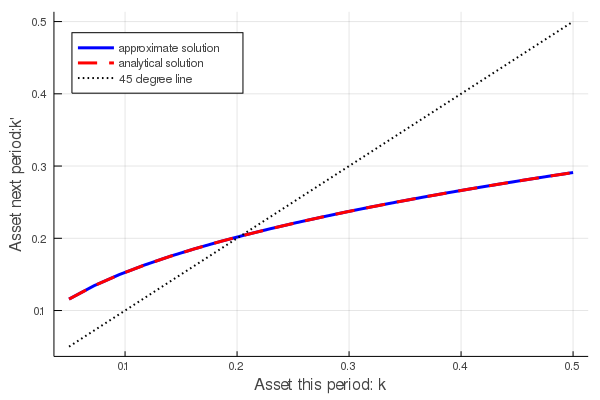

In [19]:
plot(m.kgrid,pfcn0,c=:blue,lw=3,label="approximate solution",legend=:topleft);
plot!(m.kgrid,p_true,ls=:dash,c=:red,lw=3,label="analytical solution");
plot!(m.kgrid,kgrid,ls=:dot,c=:black,lw=2,label="45 degree line");
xlabel!("Asset this period: k")
ylabel!("Asset next period:k'")

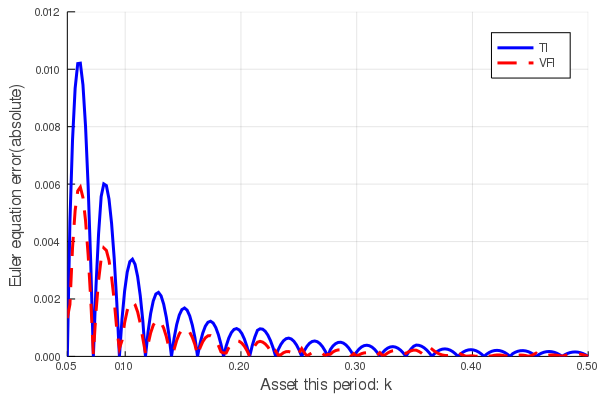

In [24]:
err2 = readdlm("err_ndp.csv");

plot(kgrid_err,abs.(err),c=:blue,lw=3,label="TI")
plot!(kgrid_err,abs.(err2),ls=:dash,c=:red,lw=3,label="VFI")
xlabel!("Asset this period: k")
ylabel!("Euler equation error(absolute)")
xlims!(m.kmin,m.kmax)
ylims!(0,0.012)
xticks!([0.05,0.1,0.2,0.3,0.4,0.5])
yticks!([0,0.002,0.004,0.006,0.008,0.01,0.012])

